# BI MASTER 2019-02: Trabalho da disciplina **OP - Otimização de Planejamento**
## Aluno: Leonardo Cardoso Vicente (https://github.com/lcvicente)


---

# **Tema do Trabalho**

## Identificar uma carteira de ações que otimize o resultado de três objetivos  conjuntos:
- Minimizar a correlação total da carteira (média entre a correlação dos pares de ações).
- Maximizar o retorno total da carteira (diferença percentual entre o primeiro e o último dia do período avaliado).
- Maximizar a quantidade de dias que a carteira possui variação diária positiva dentro do período avaliado.

Os dados processados fazem referência às cotações das ações na Bolsa de Valores Brasileira (B3) no período entre 2018 e 2020.

Os dados foram coletados por notebook separado e consolidados num dataframe Excel que é importado neste notebook.

O processamento da otimização é feito através de algoritmos genéticos usando a biblioteca `deap`.

---

# **Detalhamento dos objetivos**

## Minimizar a correlação total da carteira

É desejável que as ações escolhidas tenham baixa correlação entre si, aumentando assim a diversificação da carteira.

!["Alta correlação"](https://drive.google.com/uc?export=view&id=1maXP14wbQaLNVhal0vbXCXzhlzc_pmT5)

!["Baixa correlação"](https://drive.google.com/uc?export=view&id=1fyMIp4IZ3eJ74H-4p7dzbjspmpD-ZAcs)


## Maximizar o retorno total da carteira

Esta é a função que mede o retorno efetivo da carteira. Diferença entre o valor total investido e o valor ao fim do período.

Diferença percentual entre o primeiro e o último dia do período avaliado.

!["Retorno negativo"](https://drive.google.com/uc?export=view&id=1U7eT8PTN5XrDzyFrsDFtEu8qKR6fRYXv)

!["Retorno positivo"](https://drive.google.com/uc?export=view&id=1ahLdK6zPjQ6j02_tYdZdI-80XpY2ZwtE)

## Maximizar a quantidade de dias que a carteira possui variação diária positiva

É desejável que a variação diária dentro do período tenha a maior quantidade de dias com sinal positivo, independente do tamanho da variação.

!["Dias Positivo"](https://drive.google.com/uc?export=view&id=11NQ2HLCtmGKPTIDvzJBUGDaLMHiVbcy8)


## Função objetivo final

A função objetivo final se dá pela junção dos resultados dos três objetivos. 

Todos os objetivos possuem o mesmo peso, sendo que o objetivo de correlação possui sinal negativo.

$ FO = - fo\_correlacao + fo\_retorno\_medio + fo\_dias\_variacao\_positiva $ 

---

# **Cenários de otimização** (estrutura do notebook)

O desenvolvimento do notebook é guiado pelas seguintes definições e cenários para contextualização da problemática.

## Definições gerais

Os dados contém as cotações diárias de <font color='blue'>196</font> ações distintas entre 2018 e 2020.

Dado um período de análise (ex.: mês de dezembro de 2020), o algoritmo deve identificar uma carteira de ações que atenda conjuntamente aos objetivos definidos.

Restrições da carteira:

- Ser composta por <font color='blue'> pelo menos 7 ações</font> e <font color='blue'>no máximo 10 ações</font>.
- Dentre os pares de combinação de ações escolhidas, <font color='blue'>não deve ter par de ação com correlação maior que 0.8</font>.

## Avaliação das métricas do processamento do AG

Nesta parte é feita a otimização da carteira para um mês específico e analisadas as métricas resultantes do AG.

## Simulação de carteira otimizada

Nesta parte é feita a seguinte simulação para cada mês entre 2018 e 2020:
- Otimizar uma carteira considerando o mês $i$.
- Usar a carteira otimizada para investir no mês $i+1$.
- Comparar o retorno com a variação do índice BOVESPA no período.


# Definições iniciais

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from itertools import combinations
import random
import os

In [ ]:
# Parâmetros de gráfico
plt.rcParams["figure.figsize"] = (20, 10)
COLOR_CARTEIRA = 'gold'
COLOR_IBOV = 'silver'

In [ ]:
# Montagem Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
workdir_path = '/content/drive/MyDrive/ag_acoes'
os.chdir(workdir_path)

Mounted at /content/drive


In [ ]:
# Para uso em ambiente local
# workdir_path = r'C:\Users\Leonardo\Google Drive\ag_acoes'
# os.chdir(workdir_path)

# Funções para tratamento inicial dos dados

In [ ]:
def insere_rodada(df):
  """
  Com base na definição que a carteira é reavaliada a cada mês, cria uma coluna
  no dataframe definindo a qual rodada pertence cada linha.
  Em outras palavras, cada mês fica associado a uma nova rodada.
  O nome da rodada recebe a junção ano-mes
  """
  df['rodada'] = df['date'].apply(lambda x: "{}-{:02d}".format(x.year, x.month))

  return df

In [ ]:
def converte_variacao_diaria(df):
  """
  Converte os valores para a variação diária de cada ação
  """
  # Verifica as colunas de valores
  cols = [c for c in df.columns if c not in ['date', 'rodada']]

  # Valores atuais (T0)
  values_t0 = df[cols].values

  # Valores anteriores (T-1)
  values_t_menos_1 = df[cols].values[:-1] # Pega até a penúltima linha
  nulls = np.array([np.nan for _ in range(values_t_menos_1.shape[1])]).reshape(1, -1) # Valores para preencher com nulo
  values_t_menos_1 = np.concatenate([nulls, values_t_menos_1]) # Insere nulo no início

  # Realiza o cálculo
  df[cols] = values_t0 / values_t_menos_1 - 1

  # Apaga nulos
  df.dropna(axis='index', how='any', inplace=True)

  # Retorno
  return df


# Leitura e transformação dos dados

In [ ]:
# Lê os dados filtrando a partir de 2018
df = pd.read_excel('df_yahoo_finance.xlsx', usecols=['symbol', 'date', 'adjclose'])
df['ano'] = df['date'].apply(lambda x: x.year)
df = df.loc[df['ano'] >= 2018]
df.drop(columns=['ano'], inplace=True)
df.head()

,symbol,date,adjclose
297,AALR3,2018-01-02,14.740349
298,AALR3,2018-01-03,14.809646
299,AALR3,2018-01-04,14.938338
300,AALR3,2018-01-05,14.898741
301,AALR3,2018-01-08,14.641355


In [ ]:
# Insere a coluna da rodada
df = insere_rodada(df)
df.head()

,symbol,date,adjclose,rodada
297,AALR3,2018-01-02,14.740349,2018-01
298,AALR3,2018-01-03,14.809646,2018-01
299,AALR3,2018-01-04,14.938338,2018-01
300,AALR3,2018-01-05,14.898741,2018-01
301,AALR3,2018-01-08,14.641355,2018-01


In [ ]:
# Coloca os nomes das ações como colunas e o valores em função da coluna PREULT
df = pd.pivot_table(df, values='adjclose', index=['date', 'rodada'], columns='symbol').reset_index()
df.sort_values(by='date', inplace=True)
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

df.head()

symbol,rodada,AALR3,AAPL34,ABCB4,ABEV3,AGRO3,ALPA4,ALUP11,AMAR3,AMZO34,ANIM3,ARZZ3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BERK34,BIDI11,BIDI4,BKBR3,BMEB4,BOAC34,BPAC11,BPAN4,BRAP3,BRAP4,BRDT3,BRFS3,BRKM3,BRKM5,BRML3,BRPR3,BRSR6,BTOW3,CAML3,CARD3,CCPR3,...,SEER3,SGPS3,SHOW3,SHUL4,SLCE3,SMLS3,SMTO3,STBP3,SULA11,SUZB3,TAEE11,TCSA3,TECN3,TEND3,TESA3,TEXA34,TGMA3,TIET11,TIET4,TOTS3,TRIS3,TRPL4,TSLA34,TUPY3,UGPA3,UNIP6,USIM3,USIM5,VALE3,VERZ34,VISA34,VIVT3,VLID3,VULC3,VVAR3,WALM34,WEGE3,WIZS3,WSON33,^BVSP
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2018-01,14.740349,13.518736,13.891431,19.844748,11.013517,13.622547,16.788988,7.79,24.723566,9.388567,52.880272,27.150000,20.610033,27.917187,17.895668,18.804844,21.278070,9.731302,32.215000,NaN,NaN,17.547417,3.434962,22.822309,16.620155,1.737753,21.166872,24.784779,NaN,37.270000,37.777859,38.075958,11.446580,10.138370,12.267929,19.768276,7.038742,9.144549,7.826432,...,27.029711,10.90,7.059052,2.136801,10.495687,40.749172,17.758696,3.398175,15.228990,18.297859,15.793187,21.100000,3.73,9.346263,15.20,18.818993,17.285950,9.355400,2.009473,9.744238,1.846179,11.482757,6.8575,16.588713,35.325966,11.384385,11.265468,9.311539,35.877056,25.493391,18.326275,31.248180,17.312397,9.29,7.698611,18.952105,18.377413,8.606780,29.988153,77891.0
2018-01-03,2018-01,14.809646,13.506730,13.950080,19.890491,11.004826,13.289725,16.660969,8.30,24.891464,9.454451,54.477009,27.059999,20.960878,28.273249,17.971798,18.891293,21.292896,9.659815,32.355000,NaN,NaN,17.725662,3.649646,22.730722,16.778442,1.756141,21.500345,25.019070,NaN,37.000000,37.777859,37.754753,11.409657,10.457307,12.325640,19.610130,7.029740,9.260870,8.247661,...,26.935650,10.79,7.097417,2.145999,10.586789,40.235199,17.777267,3.398175,15.656819,18.161526,15.815269,21.900000,3.75,9.317998,14.50,19.086231,17.285950,9.494054,2.040749,9.951080,1.855076,11.249317,6.8575,16.712643,34.977154,12.217056,11.343565,9.621925,35.662075,24.818438,18.490606,30.342432,17.573887,9.75,7.738552,18.949759,18.098299,8.535942,29.238449,77995.0
2018-01-04,2018-01,14.938338,13.489923,13.908189,19.780704,11.361222,13.274243,16.505514,8.20,24.849682,9.553277,56.195854,27.230000,21.095818,28.544540,18.299063,19.201262,21.337381,9.624071,32.685001,NaN,NaN,17.725662,3.506523,23.101776,16.839998,1.728558,22.292330,25.730312,NaN,37.400002,37.777859,38.327713,11.548123,10.602280,12.399841,20.143873,7.200759,9.582987,8.593067,...,27.354649,10.59,7.097417,2.161327,10.545035,40.162521,17.749405,3.348494,15.697954,18.210217,15.565048,21.900000,3.87,9.275601,14.80,19.065090,17.951460,9.413781,2.032930,9.889675,1.908459,10.940907,6.3350,17.314581,35.385628,12.087379,11.704762,10.165097,35.808262,24.879797,18.485695,30.674543,17.573887,10.00,7.798464,18.921619,17.922016,8.465105,28.571213,78647.0
2018-01-05,2018-01,14.898741,13.638796,14.109270,19.853895,11.595922,13.506446,16.551237,8.19,25.093121,9.652104,54.307945,27.200001,21.401688,28.544540,18.304619,19.310017,21.478247,9.731302,32.380001,NaN,NaN,17.626637,3.599553,22.852840,17.118427,1.774530,22.425716,26.349516,NaN,39.240002,38.047081,39.256607,11.585049,10.795575,12.562648,19.768276,7.362777,9.377190,8.593067,...,27.012608,10.64,7.145372,2.164393,10.742421,39.975620,17.554356,3.467729,15.747318,18.161526,15.638643,21.700001,4.04,9.515852,14.72,19.010344,18.150249,9.559730,2.025110,10.102980,1.912908,11.116412,6.3350,17.332283,35.459061,12.278483,11.997625,9.728619,36.367233,24.835970,18.708401,30.750023,17.537819,10.00,7.548833,18.977898,17.995468,8.585529,28.646181,79071.0
2018-01-08,2018-01,14.641355,13.600377,14.243323,19.817299,11.648077,13.235544,16.459795,8.33,25.602547,9.717990,53.641071,26.910000,21.500643,28.612360,18.304619,19.304581,21.604282,9.400670,32.792999,NaN,NaN,17.626637,3.506523,23.003138,17.328188,1.802114,22.675819,26.809732,NaN,39.700001,39.836102,39.326057,11.538891,10.824569,12.773007,19.610130,7.353775,9.851418,8.677314,...,27.063913,10.69,7.24128

In [ ]:
# Retira ações que contenham valores nulos
acoes_null = df.isnull().sum()!=0
print("Ações com valores nulos: {}".format(" - ".join(acoes_null[acoes_null==True].index)))
df.dropna(axis='columns', inplace=True)

Ações com valores nulos: BIDI11 - BIDI4 - BRDT3 - GNDI3 - HAPV3 - JSLG3 - LOGG3


In [ ]:
# Separa o dataframe do índice BOVESPA
df_bovespa = df[['rodada', '^BVSP']].copy()
df = df[[c for c in df.columns if c != '^BVSP']].copy()

In [ ]:
# Verifica as ações existentes
LIST_ACOES = [col for col in df.columns if col not in ['rodada']]
print("O dataset possui {} ações".format(len(LIST_ACOES)))

O dataset possui 196 ações


In [ ]:
# Converte os valores para sua variação diária
df_var = converte_variacao_diaria(df.copy())

In [ ]:
# Verificando correlações
# rodada = df['rodada'].unique()[-1]
# df_corr = df.loc[df['rodada']==rodada].dropna(axis=1).drop(columns=['rodada']).corr()
# correlations = df_corr.values.flatten()

# plt.figure(figsize=(20,5))
# sns.distplot(correlations, color="Red", label="Correlações")
# plt.xlabel("Correlação")
# plt.ylabel("Densidade")
# plt.title("Frequência de correlação - Rodada {}".format(rodada)); 
# plt.legend();

# Funções objetivos

In [ ]:
# Datasets para processamento
DF_VALORES = df.copy()
DF_VARIACAO = df_var.copy()

In [ ]:
def fo_correlacao_carteira(df, carteira, list_rodadas):
  """
  Verifica a correlação média das ações recebidas em `carteira` dentro do
  dataframe `df`
  """
  # Retira repetições
  carteira = list(set(carteira))
  
  # Filtra o dataframe com o período e a carteira
  df_carteira = df.loc[df['rodada'].isin(list_rodadas), carteira]

  # Gera a matriz de correlação
  df_corr = df_carteira.corr().reset_index()
  df_corr = df_corr.melt(['symbol'], var_name='acao', value_name='corr')

  # Verifica a correlação média (não precisa dividir por 2 para tirar o efeito do
  # espelhamento, pois esse efeito é tirado na média)
  media_corr = df_corr.loc[df_corr['symbol'] != df_corr['acao'], 'corr'].describe()['mean']

  # Retira o sinal
  # media_corr = abs(media_corr)

  # Retorno
  return media_corr

In [ ]:
def fo_correlacao_carteira_dic(dic_corr, carteira):
  """
  Verifica a correlação média das ações recebida
  """
  # Retira repetições
  carteira = list(set(carteira))

  # Gera as combinações sem repetição
  comb = combinations(carteira, 2)

  # Verifica a correlação média
  corr_sum = [dic_corr[x] for x in comb]
  resp = sum(corr_sum) / len(carteira)

  # Retira o sinal
  # resp = abs(resp)

  # Retorno
  return resp

In [ ]:
def fo_retorno_medio(df, carteira, list_rodadas):
  """
  Verifica o rendimento final da carteira considerando o primeiro e o último dia
  do período
  """
  
  # Retira repetições
  carteira = list(set(carteira))

  # Filtra o dataframe com o período e a carteira
  df_carteira = df.loc[df['rodada'].isin(list_rodadas), carteira]

  # Calcula a última linha sobre a primeira
  retorno_medio = (df_carteira.iloc[-1] / df_carteira.iloc[0] - 1).mean()

  # Retorno
  return retorno_medio

In [ ]:
def fo_retorno_medio_dic(dic_ret, carteira):
  """
  Verifica o retorno médio consultando no dicionário
  """
  
  # Retira repetições
  carteira = list(set(carteira))

  # Verifica o retorno médio
  ret_sum = [dic_ret[x] for x in carteira]
  resp = sum(ret_sum) / len(carteira)

  # Retorno
  return resp

In [ ]:
def fo_dias_retorno_positivo(df, carteira, list_rodadas):
  """
  Verifica a média percentual de dias em que a carteira teve retorno positivo
  """
  
  # Retira repetições
  carteira = list(set(carteira))

  # Filtra o dataframe com o período e a carteira
  df_carteira = df.loc[df['rodada'].isin(list_rodadas), carteira]

  # Verifica o retorno médio diário
  ret_med_dia = df_carteira.mean(axis='columns')

  # Calcula o percentual de dias com retorno positivo
  perc_pos = ret_med_dia.loc[ret_med_dia > 0].count() / df_carteira.shape[0]

  # Retorno
  return perc_pos

In [ ]:
def fo_principal(carteira, list_rodadas, dic_corr, dic_ret, retornar_fo_individual=False, normalizar=False):
  """
  Aplica o fator em cada função objetivo após normalizá-la
  """

  # Fatores
  F_CORRELACAO = -1
  F_MEDIA_RETORNO = 1
  F_DIAS_RET_POSITIVO = 1

  # Calcula a função objetivo
  fo_corr = fo_correlacao_carteira_dic(dic_corr, carteira)
  fo_ret_med = fo_retorno_medio_dic(dic_ret, carteira) / len(list_rodadas)
  fo_dias_pos = fo_dias_retorno_positivo(DF_VARIACAO, carteira, list_rodadas)

  # Normaliza os valores
  if normalizar:
    fo_corr = (fo_corr - DIC_NORM['corr'].mean_[0]) / DIC_NORM['corr'].scale_[0]
    fo_ret_med = (fo_ret_med - DIC_NORM['ret_medio'].mean_[0]) / DIC_NORM['ret_medio'].scale_[0]
    fo_dias_pos = (fo_dias_pos - DIC_NORM['dias_pos'].mean_[0]) / DIC_NORM['dias_pos'].scale_[0]

  # Verifica se é para retornar os resultados sem normalização e sem agregação
  if retornar_fo_individual:
    return {'fo_corr': fo_corr, 'fo_ret_med': fo_ret_med, 'fo_dias_pos': fo_dias_pos}


  # Aplica os fatores
  fo = (fo_corr * F_CORRELACAO) + (fo_ret_med * F_MEDIA_RETORNO) + (fo_dias_pos * F_DIAS_RET_POSITIVO)

  # Retorno
  return fo


# Definição dos parâmetros gerais para o AG

In [ ]:
# Parâmetros para o processamento do AG
MIN_IDX_ACAO = 0 # Menor índice de ação
MAX_IDX_ACAO = len(LIST_ACOES) - 1 # Maior índice de ação
QTDE_ACOES_ESCOLHA = 10 # Quantidade de açoes para compor a carteira
QTDE_MINIMA_ACOES = 7 # Quantidade mínima de ações para a carteira
MIN_CORRELACAO = 0.8 # Correlação mínima entre pares de ações

TAMANHO_POPULACAO = 500
QTDE_GERACOES = 300
PROB_MUTACAO = 0.15
PROB_X_OVER = 0.15

# Calibrando a normalização de cada função objetivo para uso na avaliação

Gera cromossomos aleatórios para verificar o range de resposta de cada função objetivo

In [ ]:
# Gerando cromossomos para cada rodada
N_CROMOS_ALEAT = 1000
choices = []
for rodada in df['rodada'].unique():
  list_carteira = []
  for _ in range(N_CROMOS_ALEAT):
    carteira = np.random.choice(len(LIST_ACOES), QTDE_ACOES_ESCOLHA, replace=False)
    carteira = sorted([LIST_ACOES[i] for i in carteira])
    if carteira not in list_carteira:
      list_carteira.append(carteira)
  choices += [[rodada, carteira] for carteira in list_carteira]

Submete os cromossomos para cada função objetivo

In [ ]:
fo_corr = []
fo_ret_medio = []
fo_perc_dias_pos = []
for rodada, carteira in tqdm(choices):
  fo_corr.append(fo_correlacao_carteira(df, carteira, [rodada]))
  fo_ret_medio.append(fo_retorno_medio(df, carteira, [rodada]))
  fo_perc_dias_pos.append(fo_dias_retorno_positivo(df_var, carteira, [rodada]))

100%|██████████| 36000/36000 [07:21<00:00, 81.47it/s]


Gera o dataframe com os resultados

In [ ]:
df_calibragem = pd.DataFrame(data=zip(fo_corr, fo_ret_medio, fo_perc_dias_pos), columns=['corr', 'ret_medio', 'dias_pos'])
df_calibragem.head()

,corr,ret_medio,dias_pos
0,0.008581,0.060209,0.523810
1,0.253426,0.072108,0.571429
2,0.100520,0.056405,0.571429
3,0.015870,0.036386,0.476190
4,0.163565,0.069268,0.571429


Verificando distribuição

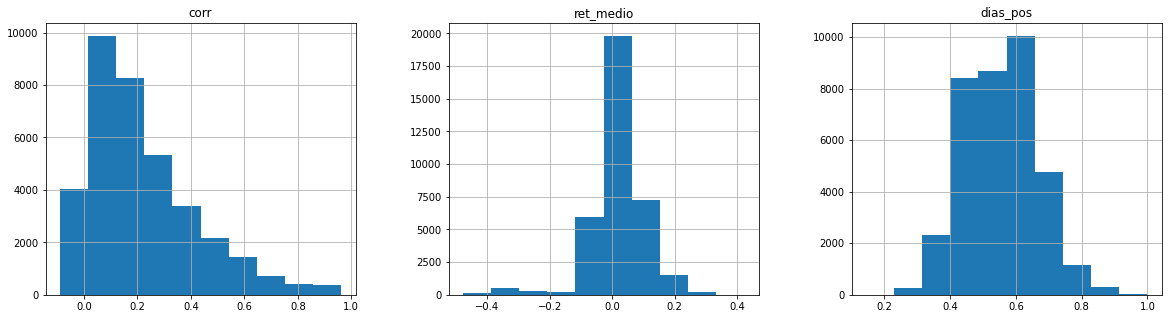

In [ ]:
df_calibragem.hist(figsize=(20, 5), layout=(1, 3));

In [ ]:
df_calibragem.describe()

,corr,ret_medio,dias_pos
count,36000.000000,36000.000000,36000.000000
mean,0.217833,0.018896,0.552866
std,0.200201,0.088320,0.110121
min,-0.090782,-0.479454,0.142857
25%,0.068724,-0.016959,0.476190
50%,0.167844,0.021048,0.550000
75%,0.318544,0.062587,0.631579
max,0.963504,0.424096,1.000000


Armazenando fator de normalização de cada variável

In [ ]:
from sklearn.preprocessing import StandardScaler

DIC_NORM = {}
for col in df_calibragem.columns:
  DIC_NORM[col] = StandardScaler().fit(df_calibragem[[col]])

Aplicando a normalização nos dados de calibração e verificando as estatísticas

In [ ]:
for col in df_calibragem.columns:
  df_calibragem[col] = DIC_NORM[col].transform(df_calibragem[col].values.reshape(-1, 1))

df_calibragem.describe()

,corr,ret_medio,dias_pos
count,3.600000e+04,3.600000e+04,3.600000e+04
mean,-1.731177e-16,-3.855589e-16,4.895974e-15
std,1.000014e+00,1.000014e+00,1.000014e+00
min,-1.541541e+00,-5.642610e+00,-3.723306e+00
25%,-7.448058e-01,-4.059691e-01,-6.962949e-01
50%,-2.496953e-01,2.436988e-02,-2.602809e-02
75%,5.030554e-01,4.946979e-01,7.147931e-01
max,3.724656e+00,4.587909e+00,4.060437e+00


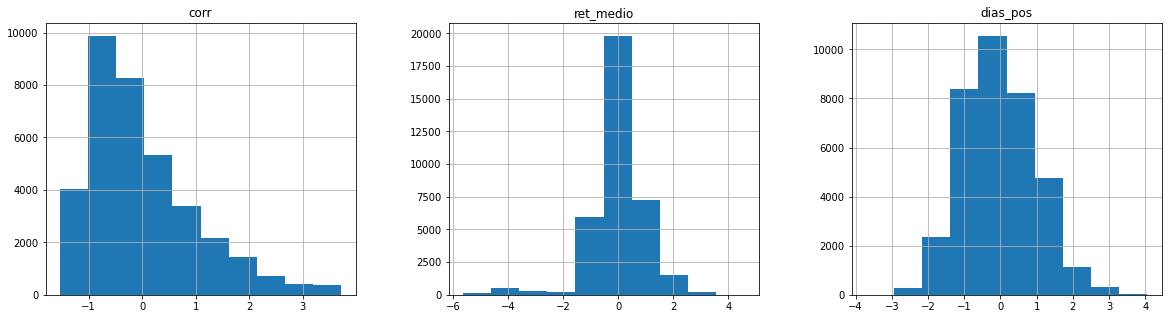

In [ ]:
df_calibragem.hist(figsize=(20, 5), layout=(1, 3));

# Configuração do AG

In [ ]:
# Importação de bibliotecas
!pip install deap
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [ ]:
def gera_dic_correlacao(df, list_periodos):
  """
  Gera dicionário de correlação no período para evitar consultar frequentemente
  o dataframe
  """
  # Gera a matriz de correlação e armazena num dicionário
  df_corr = df.loc[df['rodada'].isin(list_periodos)].corr().reset_index()
  df_corr = df_corr.melt(['symbol'], var_name='acao', value_name='corr')
  df_corr['tupla'] = tuple(zip(df_corr['symbol'], df_corr['acao']))
  dic = df_corr[['tupla', 'corr']].set_index('tupla')['corr'].to_dict()

  # Retorno
  return dic

In [ ]:
def gera_dic_retorno(df, list_periodos):
  """
  Gera dicionário de retorno no período para evitar consultar frequentemente
  o dataframe
  """
  # Filtra o dataframe com o período e a carteira
  df_retorno = DF_VALORES.loc[df['rodada'].isin(list_periodos), LIST_ACOES]

  # Calcula a última linha sobre a primeira
  retorno_acoes = (df_retorno.iloc[-1] / df_retorno.iloc[0] - 1)

  # Grava em dicionário
  dic = retorno_acoes.to_dict()

  # Retorno
  return dic

In [ ]:
def gerador_individuo(icls, attr_int_function):
  cromossomo = [attr_int_function() for i in range(QTDE_ACOES_ESCOLHA)]
  
  if not funcao_restricao(cromossomo):
    for _ in range(5):
      if funcao_restricao(cromossomo):
        break

  return icls(cromossomo)

In [ ]:
def funcao_restricao(individual):
  """
  Função de restrição.
  Verifica se o cromossomo possui a quantidade de ações mínimas e que não exista
  duas ações com correlação maior que o limite de correlação
  """

  # Verifica as ações pertencentes ao indivíduo
  carteira = [LIST_ACOES[i] for i in individual]
  carteira = list(set(carteira))

  # Verifica se possui a quantidade mínima
  if len(carteira) < QTDE_MINIMA_ACOES:
    return False

  # Verifica se existe algum par de ações com correlação maior que a mínima
  for acao_1, acao_2 in combinations(carteira, 2):
    if fo_correlacao_carteira_dic(DIC_CORR, [acao_1, acao_2]) > MIN_CORRELACAO:
      return False
  
  # Caso atenda às restrições
  return True

In [ ]:
def funcao_ag_fo(individual):
  """
  Para cada linha, verifica na base de sorteios quantos concursos teriam
  registrado a quantidade de acertos mínima, definida em LOT_DEZENAS_DESEJADAS_SORTEIO
  """
  # Inicializa o fitness do cromossomo
  fitness = 0

  # Verifica as ações pertencentes ao indivíduo
  carteira = [LIST_ACOES[i] for i in individual]
  carteira = list(set(carteira))
  fitness = fo_principal(carteira, PERIODO_PROC_AG, DIC_CORR, DIC_RET)

  # Retorno
  return fitness,

In [ ]:
def penalidade(individual):
  """
  Função de penalidade para o caso de um indivíduo que viole restrições.
  Aplica um fator de redução para a FO
  """
  FAT_RED = 0.4

  carteira = [LIST_ACOES[i] for i in individual]
  fo = fo_principal(carteira, PERIODO_PROC_AG, DIC_CORR, DIC_RET)
  return fo * FAT_RED

In [ ]:
def configura_ag():
  """
  Configurações de criação do AG
  """
  # Apaga objetos previamente criados
  try:
    del creator.FitnessMax
    del creator.Individual
  except:
    pass

  # Função de fitness
  creator.create("FitnessMax", base.Fitness, weights=(1.0,))

  # Indivíduo: tipo lista
  creator.create("Individual", list, fitness=creator.FitnessMax)

  # Realiza a instanciação da Tollbox
  toolbox = base.Toolbox()

  # Definir o gerador de numeros aleatórios de numeros inteiros entre o intervalo definido em 
  toolbox.register("attr_int", random.randint, MIN_IDX_ACAO, MAX_IDX_ACAO)

  # Inicialização do cromossomo (quantos genes o cromossomo deve possuir)
  toolbox.register("individual", gerador_individuo, creator.Individual, toolbox.attr_int)

  # Registro do individuo na população
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)

  # Registro do nome da função objetivo
  toolbox.register("evaluate", funcao_ag_fo)
  toolbox.decorate("evaluate", tools.DeltaPenalty(funcao_restricao, 0, distance=penalidade)) 

  # Registro de qual o tipo de cruzamento deve ser utilizado (cruzamento de 2 pontos)
  toolbox.register("mate", tools.cxTwoPoint)

  # Registro de qual tipo de mutação deve ser utilizado (probabilidade de um individuo sofrer mutação)
  toolbox.register("mutate", tools.mutUniformInt, low=MIN_IDX_ACAO, up=MAX_IDX_ACAO, indpb=PROB_MUTACAO)

  # Registro de qual o tipo do método de seleção que será utilizado
  toolbox.register("select", tools.selTournament, tournsize=10)

  # Retorno
  return toolbox

In [ ]:
def processa_ag(list_periodos):
  global PERIODO_PROC_AG
  global DIC_CORR
  global DIC_RET
  
  # Configura os parâmetros recebidos
  PERIODO_PROC_AG = list_periodos

  # Configura os dicionários para referência das fo
  DIC_CORR = gera_dic_correlacao(DF_VALORES, PERIODO_PROC_AG)
  DIC_RET = gera_dic_retorno(DF_VALORES, PERIODO_PROC_AG)

  # Cria o AG
  toolbox = configura_ag()

  # Inicialização da população
  pop = toolbox.population(n=TAMANHO_POPULACAO)                         

  # Melhores indivíduos a serem guardados
  hof = tools.HallOfFame(3)

  # Estatísticas
  stats = tools.Statistics(lambda ind: ind.fitness.values) 
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)

  # Processa o AG

  pop, log = algorithms.eaSimple(
      pop,
      toolbox,
      cxpb=PROB_X_OVER,
      mutpb=PROB_MUTACAO,
      ngen=QTDE_GERACOES,
      stats=stats,
      halloffame=hof,
      verbose=False
      )
  
  # Retorno
  return hof, log

# Processamento e análise do AG

Processa o AG para otimizar carteira considerando as variações do mês 2020-12

In [ ]:
# Processa o AG
# QTDE_GERACOES = 300
periodos_proc = ['2020-12']
hof, log = processa_ag(periodos_proc)

In [ ]:
# Exibe o melhor indivíduo e métricas
best = hof[0]
melhor_carteira =  sorted(set([LIST_ACOES[i] for i in best]))
print("\nMelhor carteira: {}".format(" - ".join(melhor_carteira)))

# Verificação da função de restrição
print("\nFunção de restrição: {}".format(funcao_restricao(best)))

# Métricas
print("\nMelhor Resultado da Função Objetivo - Período de avaliação (resultados normalizados)")
resp = fo_principal(melhor_carteira, periodos_proc, DIC_CORR, DIC_RET, retornar_fo_individual=True, normalizar=True)
for key in resp:
    print("   {}: {}".format(key, resp[key]))
melhor_fo = fo_principal(melhor_carteira, periodos_proc, DIC_CORR, DIC_RET)
print("   FO: {}".format(melhor_fo))


print("\nMelhor Resultado da Função Objetivo - Período de avaliação (resultados não-normalizados)")
resp = fo_principal(melhor_carteira, periodos_proc, DIC_CORR, DIC_RET, retornar_fo_individual=True, normalizar=False)
for key in resp:
    print("   {}: {}".format(key, resp[key]))




Melhor carteira: BBAS3 - BMEB4 - EVEN3 - FRAS3 - GFSA3 - JBSS3 - KLBN11 - PFIZ34 - PRIO3 - WALM34

Função de restrição: True

Melhor Resultado da Função Objetivo - Período de avaliação (resultados normalizados)
   fo_corr: -3.007961682084607
   fo_ret_med: 0.40165876187476346
   fo_dias_pos: 3.6063854346072106
   FO: 1.3887272514349003

Melhor Resultado da Função Objetivo - Período de avaliação (resultados não-normalizados)
   fo_corr: -0.38435716971400274
   fo_ret_med: 0.05437008172089762
   fo_dias_pos: 0.95


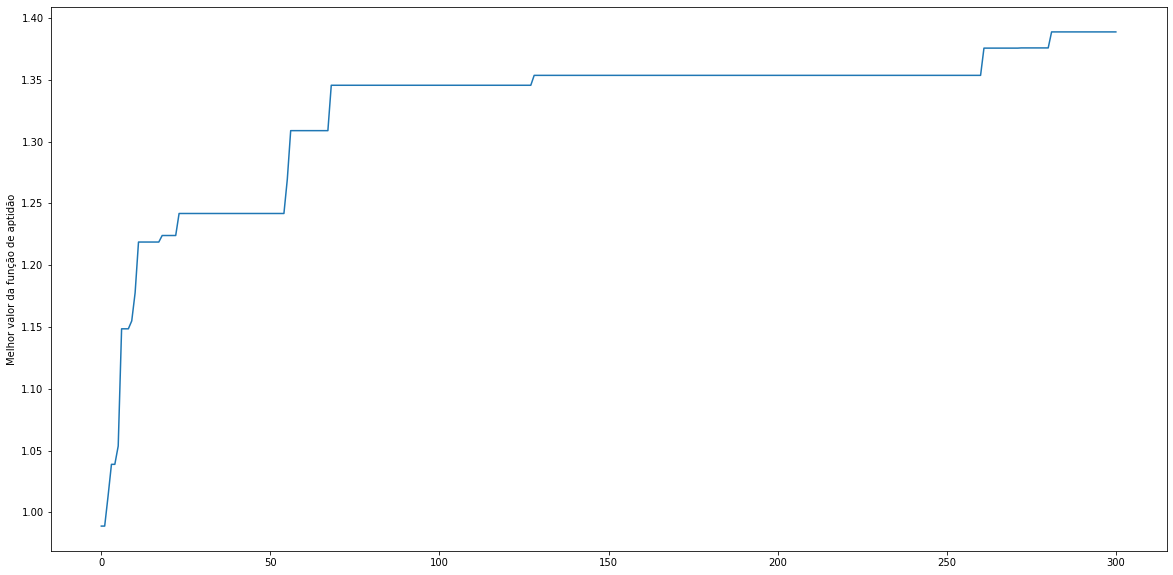

In [ ]:
# Melhor valor de aptidão por geração
gen, max, avg = log.select("gen", "max", "avg")
plt.plot(gen, max)
plt.ylabel('Melhor valor da função de aptidão')
plt.show()

Comparando o resultado com escolhas aleatórias de cromossomos

In [ ]:
# Gerando cromossomos para cada rodada
N_CROMOS_ALEAT = 10_000
choices = []
list_fo = []
for _ in tqdm(range(N_CROMOS_ALEAT)):
  carteira = np.random.choice(len(LIST_ACOES), QTDE_ACOES_ESCOLHA, replace=False)
  carteira = sorted([LIST_ACOES[i] for i in carteira])
  fo =  fo_principal(carteira, periodos_proc, DIC_CORR, DIC_RET, retornar_fo_individual=False, normalizar=False)
  list_fo.append(fo)

100%|██████████| 10000/10000 [00:25<00:00, 398.06it/s]


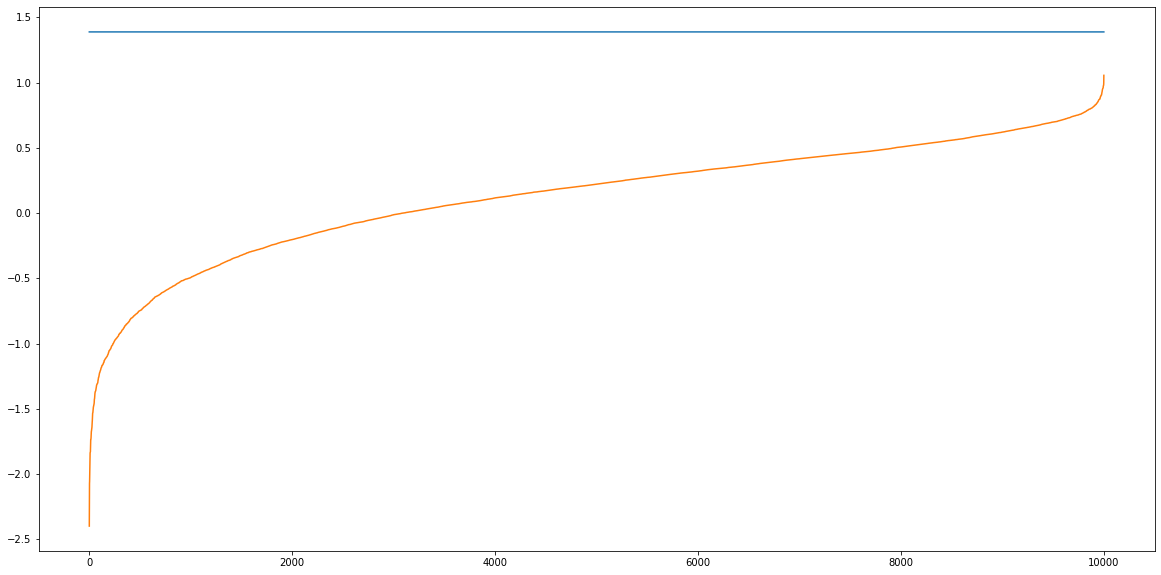

In [ ]:
# Plota gráfico comparativo
list_const_melhor = [melhor_fo for _ in range(N_CROMOS_ALEAT)]
list_idx = list(range(N_CROMOS_ALEAT))
plt.plot(list_idx, list_const_melhor, sorted(list_fo))
plt.show()

In [ ]:
# Prepara dataframe para exibição
df_norm = DF_VALORES.loc[df['rodada'].isin(PERIODO_PROC_AG), melhor_carteira]
df_base = df_norm.iloc[0]
df_norm = df_norm / df_base -1
df_norm['CARTEIRA'] = df_norm.mean(axis='columns')

# Prepara os dados do índice Bovespa
df_norm_bov = df_bovespa.loc[df_bovespa['rodada'].isin(PERIODO_PROC_AG)]
df_base = df_norm_bov.iloc[0]
df_norm['IBOVESPA'] = df_norm_bov['^BVSP'] / df_base['^BVSP'] -1

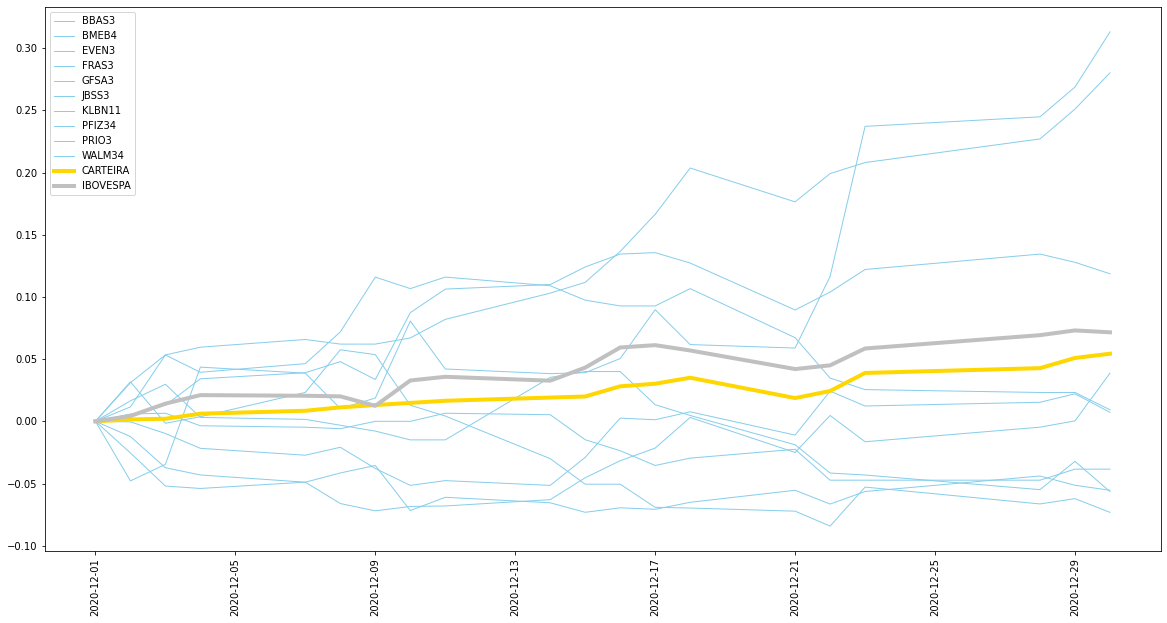

In [ ]:
# Plota graficamente
for acao in sorted(melhor_carteira):
  plt.plot('date', acao, data=df_norm.reset_index(), color='skyblue', linewidth=1)

plt.plot('date', 'CARTEIRA', data=df_norm.reset_index(), color=COLOR_CARTEIRA, linewidth=4)
plt.plot('date', 'IBOVESPA', data=df_norm.reset_index(), color=COLOR_IBOV, linewidth=4)

plt.xticks(rotation = 90)
plt.legend()
plt.show()

# Simulando investimento da carteira otimizada para o mês seguinte

In [ ]:
rodada_inicial = '2018-02'
periodos_antes = 1
periodos = DF_VALORES.loc[DF_VALORES['rodada']>=rodada_inicial, 'rodada'].unique()

RODADAS = []

for periodo in periodos:
    list_antes = DF_VALORES.loc[DF_VALORES['rodada']<periodo, 'rodada'].unique()[-periodos_antes:].tolist()
    RODADAS.append([list_antes, [periodo]])

In [ ]:
for periodos_proc, periodo_teste in RODADAS:
    print("Período de otimização [{}]. Período de investimento: {}".format(" - ".join(periodos_proc), " - ".join(periodo_teste)))

Período de otimização [2018-01]. Período de investimento: 2018-02
Período de otimização [2018-02]. Período de investimento: 2018-03
Período de otimização [2018-03]. Período de investimento: 2018-04
Período de otimização [2018-04]. Período de investimento: 2018-05
Período de otimização [2018-05]. Período de investimento: 2018-06
Período de otimização [2018-06]. Período de investimento: 2018-07
Período de otimização [2018-07]. Período de investimento: 2018-08
Período de otimização [2018-08]. Período de investimento: 2018-09
Período de otimização [2018-09]. Período de investimento: 2018-10
Período de otimização [2018-10]. Período de investimento: 2018-11
Período de otimização [2018-11]. Período de investimento: 2018-12
Período de otimização [2018-12]. Período de investimento: 2019-01
Período de otimização [2019-01]. Período de investimento: 2019-02
Período de otimização [2019-02]. Período de investimento: 2019-03
Período de otimização [2019-03]. Período de investimento: 2019-04
Período de

In [ ]:
# Processa em lote
# QTDE_GERACOES = 100
list_ret_carteira = []

for periodos_proc, periodo_teste in RODADAS:
    print("Processando [{}]. Período de teste: {}".format(" - ".join(periodos_proc), " - ".join(periodo_teste)))
    
    hof, log = processa_ag(periodos_proc)
    best = hof[0]
    melhor_carteira =  sorted(set([LIST_ACOES[i] for i in best]))
    print("\nMelhor carteira: {}".format(" - ".join(melhor_carteira)))

    # Verificação da função de restrição
    print("\nFunção de restrição: {}".format(funcao_restricao(best)))

    # Métricas
    print("\nMelhor Resultado da Função Objetivo - Período de avaliação")
    resp = fo_principal(melhor_carteira, periodos_proc, DIC_CORR, DIC_RET, retornar_fo_individual=True)
    for key in resp:
        print("   {}: {}".format(key, resp[key]))
    
    # Período de teste
    dic_corr_teste = gera_dic_correlacao(DF_VALORES, periodo_teste)
    dic_ret_teste = gera_dic_retorno(DF_VALORES, periodo_teste)
    print("\nResultado da Função Objetivo - Período de teste")
    resp = fo_principal(melhor_carteira, periodo_teste, dic_corr_teste, dic_ret_teste, retornar_fo_individual=True)
    for key in resp:
        print("   {}: {}".format(key, resp[key]))

    # Armazena o retorno
    list_ret_carteira.append(resp['fo_ret_med'])
    
    print("#" * 80)
    print()


Processando [2018-01]. Período de teste: 2018-02

Melhor carteira: AAPL34 - AMZO34 - EMBR3 - MCDC34 - MOVI3 - MSCD34 - PINE4 - SAPR3 - TEND3 - TIET4

Função de restrição: True

Melhor Resultado da Função Objetivo - Período de avaliação
   fo_corr: -0.3977547752188964
   fo_ret_med: 0.05039265741416503
   fo_dias_pos: 0.8571428571428571

Resultado da Função Objetivo - Período de teste
   fo_corr: 0.136837470408694
   fo_ret_med: -0.007696205390822886
   fo_dias_pos: 0.47058823529411764
################################################################################

Processando [2018-02]. Período de teste: 2018-03

Melhor carteira: BPAN4 - CAML3 - GPIV33 - JPSA3 - ODPV3 - ROMI3 - SHOW3 - UNIP6 - WSON33

Função de restrição: True

Melhor Resultado da Função Objetivo - Período de avaliação
   fo_corr: -0.4534594732183228
   fo_ret_med: 0.07890315997702935
   fo_dias_pos: 0.8823529411764706

Resultado da Função Objetivo - Período de teste
   fo_corr: -0.14161856362006986
   fo_ret_med: -0.

Comparando mês a mês com o índice BOVESPA

In [ ]:
# Armazena o retorno do índice BOVESPA
list_ret_bovespa = []
for _, periodo_teste in RODADAS:
  df_bov_periodo = df_bovespa.loc[df_bovespa['rodada'].isin(periodo_teste)].copy()
  ret_bovespa = df_bov_periodo['^BVSP'].iloc[-1] / df_bov_periodo['^BVSP'].iloc[0] -1
  list_ret_bovespa.append(ret_bovespa)

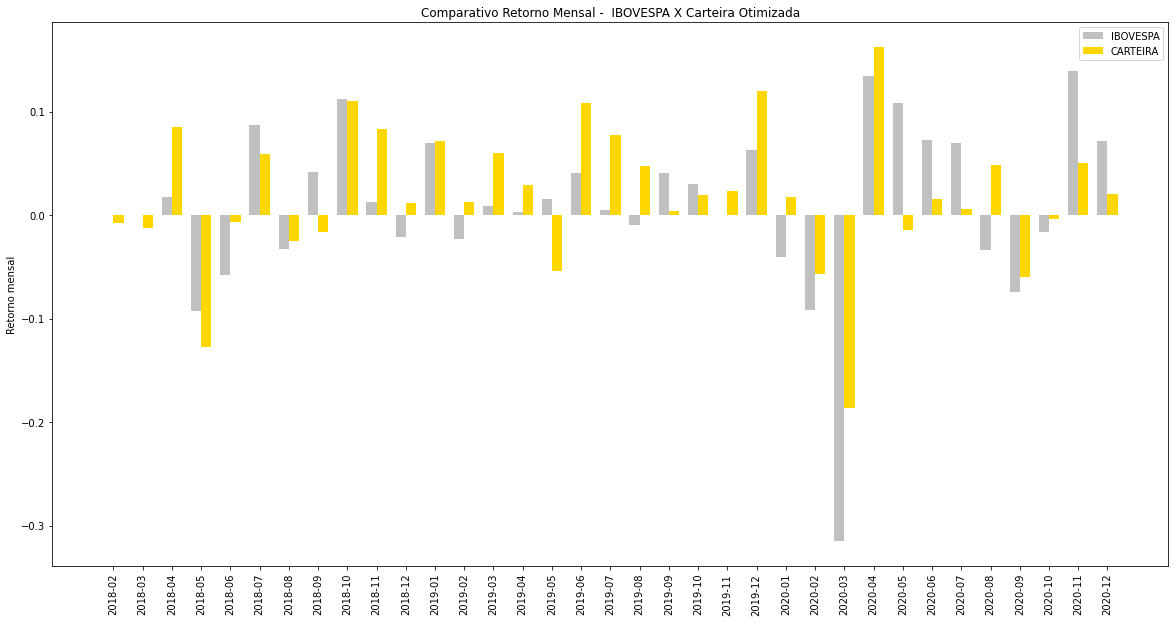

In [ ]:
# Plota
labels = [periodo[0] for _, periodo in RODADAS]

x = np.arange(len(labels))  # the label locations
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, list_ret_bovespa, width, label='IBOVESPA', color=COLOR_IBOV)
rects2 = ax.bar(x + width/2, list_ret_carteira, width, label='CARTEIRA', color=COLOR_CARTEIRA)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Retorno mensal')
ax.set_title('Comparativo Retorno Mensal -  IBOVESPA X Carteira Otimizada')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.xticks(rotation = 90)

plt.show()

In [ ]:
# Prepara os dados de retorno acumulado
ret_acm_bovespa = []
ret_acm_carteira = []
acm_bov = 1
acm_cart = 1
for bov, cart in zip(list_ret_bovespa, list_ret_carteira):
  acm_bov = (bov + 1) * acm_bov
  acm_cart = (cart + 1) * acm_cart
  
  ret_acm_bovespa.append(acm_bov - 1)
  ret_acm_carteira.append(acm_cart - 1)

df_ret_acm = pd.DataFrame(data=zip(labels, ret_acm_bovespa, ret_acm_carteira), columns=['Período', 'IBOVESPA', 'CARTEIRA'])

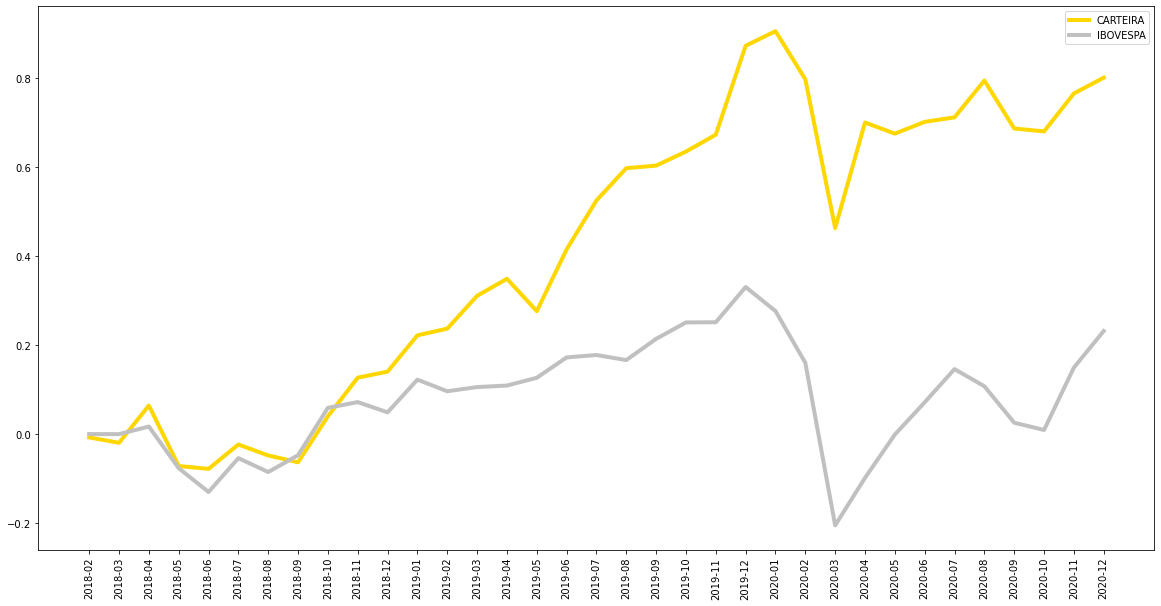

In [ ]:
plt.plot('Período', 'CARTEIRA', data=df_ret_acm, color=COLOR_CARTEIRA, linewidth=4)
plt.plot('Período', 'IBOVESPA', data=df_ret_acm, color=COLOR_IBOV, linewidth=4)

plt.legend()
plt.xticks(rotation = 90)
plt.show()

# Notebook disponível em https://github.com/lcvicente